In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder

import random

import copy
from sklearn.metrics import classification_report, confusion_matrix

import tarfile

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline

from sklearn.metrics import f1_score

from tqdm import tqdm
import wandb

from glob import glob

import cv2 
import time
from datetime import timedelta, datetime
from PIL import Image
import PIL
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


# Accelerate parts
from accelerate import Accelerator, notebook_launcher # main interface, distributed launcher
from accelerate.utils import set_seed # reproducability across devices

In [2]:
SEED_VAL = 7
N_CLASSES_main = 1
N_CLASSES_js = 30



def seed_everything(seed: int):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = True
    
seed_everything(SEED_VAL)

order = torch.randint(low = 1, 
                      high = 31,
                      size = ()) 
print(order.item())

16


Ensures that if we rerun the same code, the random operations (shuffling, data splits, etc.) will give the exact same result, allowing for consistent experiments.

In [3]:
class Custom_dataset_RainDS(Dataset):
    def __init__(self, 
                 base_folder_path: str,
                 transforms = None,
                 mode: str = "train"):
        self.base_folder_path = base_folder_path
        self.transforms = transforms
        self.mode = mode
        
        fPath_GT = os.path.join(base_folder_path, "gt")
        fPath_rdrop = os.path.join(base_folder_path, "raindrop")
        fPath_rstreak= os.path.join(base_folder_path, "rainstreak")
        fPath_rdrop_rstreak= os.path.join(base_folder_path, "rainstreak_raindrop")
        
        files_list_GT = glob(os.path.join(fPath_GT, "*.png"))
        files_list_rdrop = glob(os.path.join(fPath_rdrop, "*.png"))
        files_list_rstreak = glob(os.path.join(fPath_rstreak, "*.png"))
        files_list_rdrop_rstreak = glob(os.path.join(fPath_rdrop_rstreak, "*.png"))
        
        files_list_GT.sort()
        files_list_rdrop.sort()
        files_list_rstreak.sort()
        files_list_rdrop_rstreak.sort()
        
        self.data = []
        master_SSL_file_list = files_list_GT + files_list_rdrop + files_list_rstreak + files_list_rdrop_rstreak
        print("NUmber of images : ", len(master_SSL_file_list))
        
        for fname in master_SSL_file_list:
            # 0 : 0 degrees
            # 1 : 90 degrees
            # 2 : 180 degrees
            # 3 : 270 degrees
            for i in range(4):
                self.data.append([fname, i])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        fname, class_id = self.data[idx]
        img = cv2.imread(fname) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if class_id == 1:
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        if class_id == 2:
            img = cv2.rotate(img, cv2.ROTATE_180)
        if class_id ==3:
            img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        
        if self.transforms:
            img = self.transforms(img)
            
        return {"img": img,
                "class_id": class_id}

This class defines how to load and process the dataset.
Reading images from specific directories (like "raindrop", "rainstreak", "gt").
Storing the file paths and class IDs for each image.
Rotating images by 0°, 90°, 180°, and 270° to create augmented versions.

In [4]:
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
image_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True),
        transforms.Resize((224, 224), interpolation=PIL.Image.BILINEAR)
    ])

train_ds =  Custom_dataset_RainDS(base_folder_path = "/kaggle/input/rainds/RainDS/RainDS_real/train_set", 
                                      transforms = image_transforms,
                                      mode = "train")

NUmber of images :  600


The dataset images are converted into PyTorch tensors, normalized (using predefined mean and std values), and resized to 224x224 pixels. These steps are essential for feeding the images into deep learning models.

In [5]:
idx = 0
img, class_id = train_ds[idx]["img"], train_ds[idx]["class_id"]

In [6]:
print(img.shape)
print(class_id)

torch.Size([3, 224, 224])
0


In [7]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def get_img_by_idx(idx):
    img, _ = train_ds[idx]["img"], train_ds[idx]["class_id"]
    img = torch.unsqueeze(img,0)
    img = denormalize(img, *stats)
    img = torch.squeeze(img, 0)
    img = img.permute(1,2,0).numpy()
    return img

Converts the normalized image values back to their original range (i.e., before normalization) for visualization. Since images were normalized, this function reverts the pixel values to make the image viewable.

In [8]:

print(len(train_ds))  # Number of images after augmentation (should be original images * 4)


2400


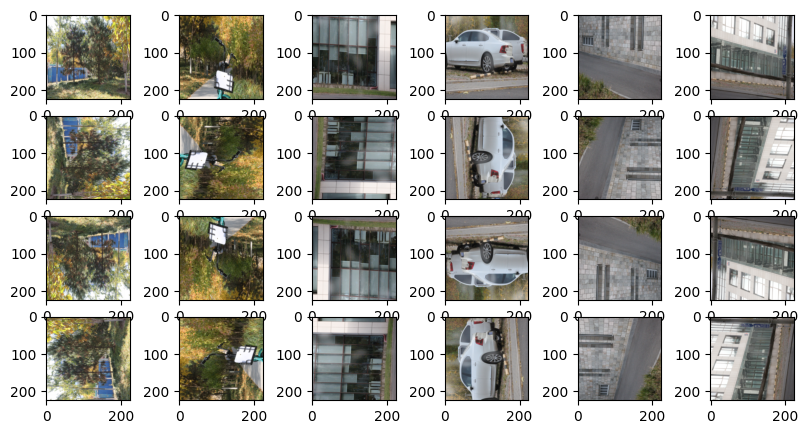

In [9]:
f, axarr = plt.subplots(4,6, figsize = (10,5))
for i in range(6):
    axarr[0,i].imshow(get_img_by_idx(4*i))
    axarr[1,i].imshow(get_img_by_idx(4*i+1))
    axarr[2,i].imshow(get_img_by_idx(4*i+2))
    axarr[3,i].imshow(get_img_by_idx(4*i+3))

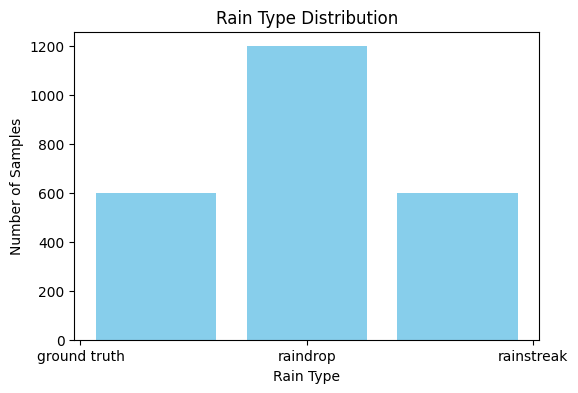

In [10]:
def plot_rain_type_distribution(dataset):
    rain_types = []  # Example rain type labels, assuming you have them
    for i in range(len(dataset)):
        img_path = dataset.data[i][0]  # Get the image path
        # Here, categorize by file path or folder name
        if "raindrop" in img_path:
            rain_types.append("raindrop")
        elif "rainstreak" in img_path:
            rain_types.append("rainstreak")
        elif "rainstreak_raindrop" in img_path:
            rain_types.append("raindrop + streak")
        else:
            rain_types.append("ground truth")

    # Plot the distribution
    plt.figure(figsize=(6, 4))
    plt.hist(rain_types, bins=len(set(rain_types)), rwidth=0.8, color='skyblue')
    plt.title("Rain Type Distribution")
    plt.xlabel("Rain Type")
    plt.ylabel("Number of Samples")
    plt.show()

# Call the function to analyze rain type distribution
plot_rain_type_distribution(train_ds)


The plot generated will show the number of images in each rain type category, which helps in understanding the distribution of rain types in the dataset (e.g., whether the dataset is balanced or skewed toward certain types of rain).

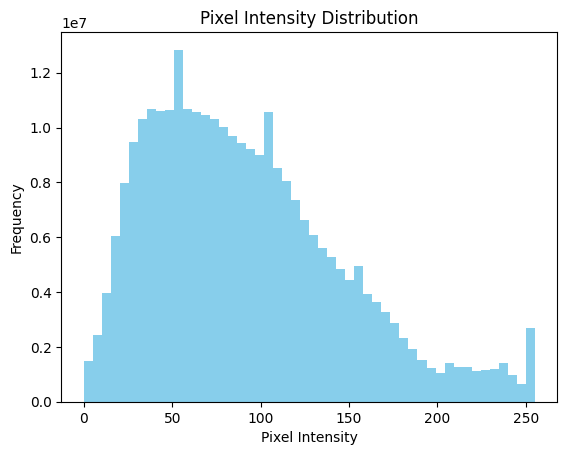

In [11]:
def load_images_to_memory(dataset, num_samples=100):
    # Load a subset of images into memory
    images = []
    for i in range(num_samples):
        img_path = dataset.data[i][0]
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img_rgb)
    return images

def plot_pixel_intensity_distribution(images):
    # Flatten and collect pixel values from all images
    pixel_values = [img.flatten() for img in images]
    pixel_values = np.concatenate(pixel_values)  # Flatten into a 1D array

    # Plot histogram
    plt.hist(pixel_values, bins=50, color='skyblue')
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Load images into memory
images_in_memory = load_images_to_memory(train_ds, num_samples=100)

# Plot pixel intensity distribution for the preloaded images
plot_pixel_intensity_distribution(images_in_memory)

 By plotting the pixel intensity distribution, this code helps to understand the brightness and contrast characteristics of the dataset. It can highlight whether the images are mostly dark, bright, or well-balanced. Based on this inference, we can try to adjust the brightness/contrast of images to make it similar across all images before training the model.

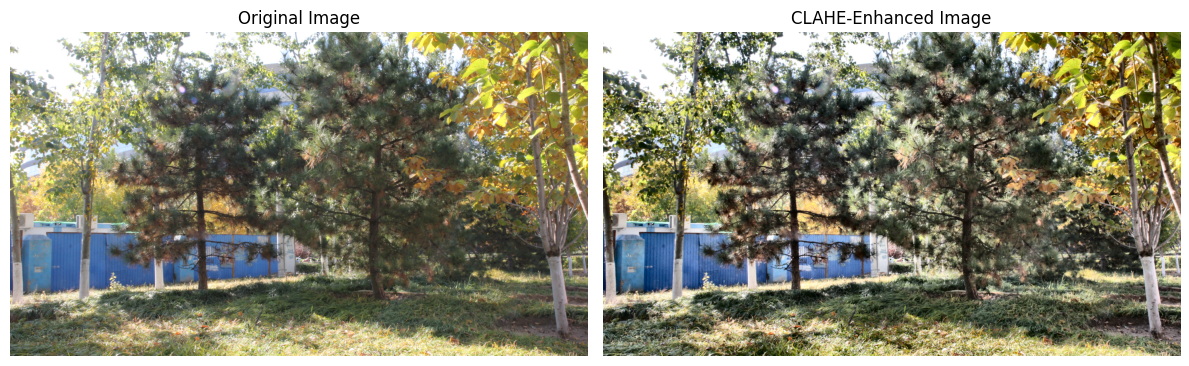

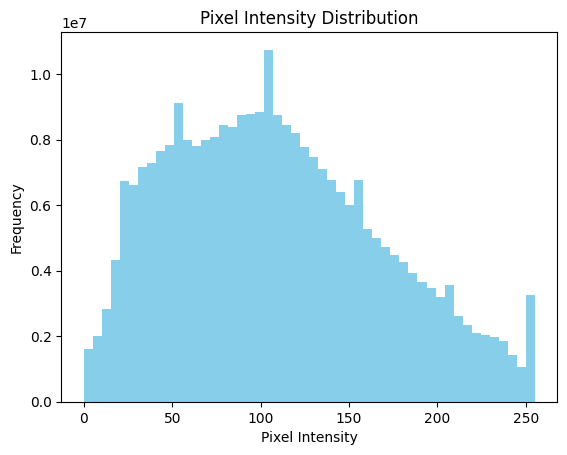

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load a subset of images into memory
def load_images_to_memory(dataset, num_samples=100):
    images = []
    for i in range(num_samples):
        img_path = dataset.data[i][0]
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img_rgb)
    return images

# Apply CLAHE for image enhancement
def apply_clahe_to_images(images):
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    
    # Apply CLAHE to each image
    enhanced_images = []
    for img in images:
        # Convert RGB image to LAB color space
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        
        # Apply CLAHE to the L-channel
        l_clahe = clahe.apply(l)
        
        # Merge the channels back
        lab_clahe = cv2.merge((l_clahe, a, b))
        
        # Convert back to RGB
        img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
        enhanced_images.append(img_clahe)
    
    return enhanced_images

# Display original and CLAHE-enhanced images side-by-side
def display_two_images(original_img, enhanced_img):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(enhanced_img)
    axes[1].set_title("CLAHE-Enhanced Image")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot pixel intensity distribution
def plot_pixel_intensity_distribution(images):
    pixel_values = [img.flatten() for img in images]
    pixel_values = np.concatenate(pixel_values)
    
    plt.hist(pixel_values, bins=50, color='skyblue')
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Load images into memory
images_in_memory = load_images_to_memory(train_ds, num_samples=100)

# Apply CLAHE for image enhancement
enhanced_images = apply_clahe_to_images(images_in_memory)

# Display just two images (original and CLAHE-enhanced)
display_two_images(images_in_memory[0], enhanced_images[0])

# Plot pixel intensity distribution for the CLAHE-enhanced images
plot_pixel_intensity_distribution(enhanced_images)


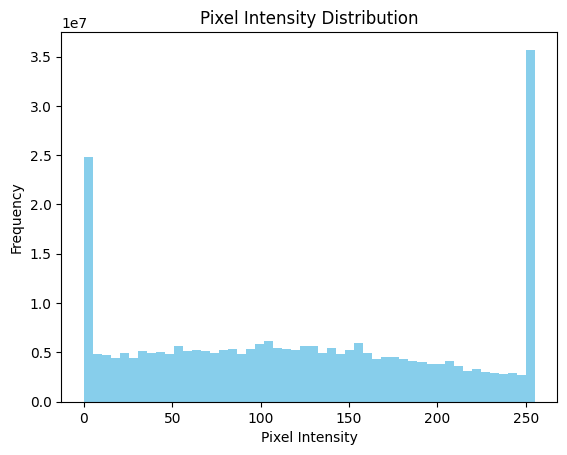

In [13]:
from PIL import ImageEnhance, Image

def adjust_image_attributes(images, sharpness_factor=1.5, brightness_factor=1.2, contrast_factor=1.3):
    # Apply sharpness, brightness, and contrast adjustments
    adjusted_images = []
    
    for img in images:
        # Convert to PIL Image for adjustments
        pil_img = Image.fromarray(img)
        
        # Adjust sharpness
        enhancer = ImageEnhance.Sharpness(pil_img)
        pil_img = enhancer.enhance(sharpness_factor)
        
        # Adjust brightness
        enhancer = ImageEnhance.Brightness(pil_img)
        pil_img = enhancer.enhance(brightness_factor)
        
        # Adjust contrast
        enhancer = ImageEnhance.Contrast(pil_img)
        pil_img = enhancer.enhance(contrast_factor)
        
        # Convert back to NumPy array (RGB)
        adjusted_img = np.array(pil_img)
        adjusted_images.append(adjusted_img)
    
    return adjusted_images

# Load images into memory
images_in_memory = load_images_to_memory(train_ds, num_samples=100)

# Apply CLAHE for image enhancement
enhanced_images = apply_clahe_to_images(images_in_memory)

# Apply sharpness, brightness, and contrast adjustments
adjusted_images = adjust_image_attributes(enhanced_images, sharpness_factor=1.5, brightness_factor=1.2, contrast_factor=1.3)

# Plot pixel intensity distribution for the adjusted images
plot_pixel_intensity_distribution(adjusted_images)


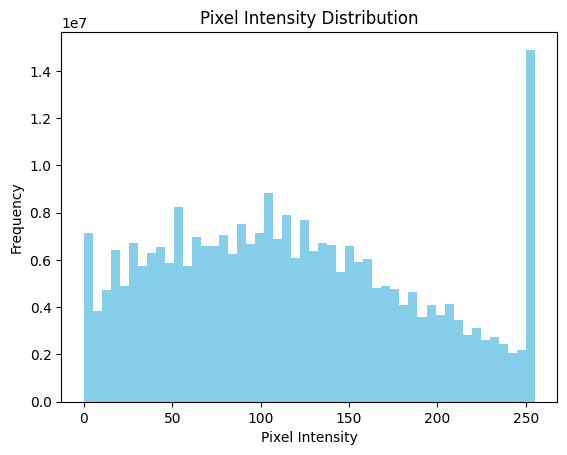

In [14]:
from PIL import ImageEnhance, Image

def adjust_image_attributes(images, sharpness_factor=1.2, brightness_factor=1.1, contrast_factor=1.1):
    # Apply sharpness, brightness, and contrast adjustments
    adjusted_images = []
    
    for img in images:
        # Convert to PIL Image for adjustments
        pil_img = Image.fromarray(img)
        
        # Adjust sharpness
        enhancer = ImageEnhance.Sharpness(pil_img)
        pil_img = enhancer.enhance(sharpness_factor)
        
        # Adjust brightness
        enhancer = ImageEnhance.Brightness(pil_img)
        pil_img = enhancer.enhance(brightness_factor)
        
        # Adjust contrast
        enhancer = ImageEnhance.Contrast(pil_img)
        pil_img = enhancer.enhance(contrast_factor)
        
        # Convert back to NumPy array (RGB)
        adjusted_img = np.array(pil_img)
        adjusted_images.append(adjusted_img)
    
    return adjusted_images

# Load images into memory
images_in_memory = load_images_to_memory(train_ds, num_samples=100)

# Apply CLAHE for image enhancement
enhanced_images = apply_clahe_to_images(images_in_memory)

# Apply more subtle sharpness, brightness, and contrast adjustments
adjusted_images = adjust_image_attributes(enhanced_images, sharpness_factor=1.2, brightness_factor=1.1, contrast_factor=1.1)

# Plot pixel intensity distribution for the adjusted images
plot_pixel_intensity_distribution(adjusted_images)
